<a href="https://colab.research.google.com/github/MuhammadMohsinAli786/Artificial-Intelligence/blob/main/amazon_reviews_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import All Required Libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sb
from sklearn import metrics
from nltk import classify
from nltk import NaiveBayesClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import math
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore",category=UserWarning)
sb.set_style("whitegrid")
get_ipython().run_line_magic('matplotlib', 'inline')

# Reading Data File

>Displaying Top 5 Records

In [4]:
csv_file = "/content/Reviews.csv"
df = pd.read_csv(csv_file)
print("Number  of  Products  for  reviews :", len(df["ProductId"].unique()))
print("Number of Unique users for reviews :", len(df["UserId"].unique()))
df.head()

Number  of  Products  for  reviews : 74258
Number of Unique users for reviews : 256059


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


### Removing Uncessary Columns

>So that we can reduce processing time to make it work for slow systems too. You can take all the 568k records if your system is efficient enough

In [6]:
data = df.copy()
data = data.drop(["Id","UserId","Time", "HelpfulnessNumerator", "HelpfulnessDenominator", "ProfileName"], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ProductId  568454 non-null  object
 1   Score      568454 non-null  int64 
 2   Summary    568427 non-null  object
 3   Text       568454 non-null  object
dtypes: int64(1), object(3)
memory usage: 17.3+ MB


In [7]:
data.head()

,ProductId,Score,Summary,Text
0,B001E4KFG0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,2,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,5,Great taffy,Great taffy at a great price. There was a wid...


### Getting only unique Products

In [8]:
asins_unique = len(data["ProductId"].unique())
print(f"Number of Unique Product IDs: {asins_unique}")

Number of Unique Product IDs: 74258


# Ploting Score Graphs

>So that we will get the overview, without calculating number of each score

## Histogram

>This graph is showing how many reviews get a specific score

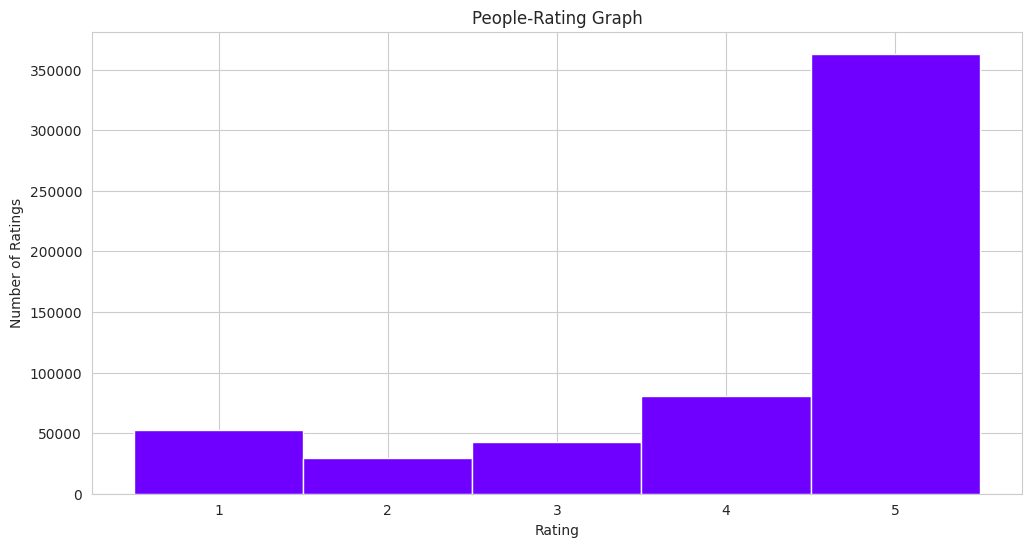

In [9]:
x_axis_rating = data["Score"]
x_axis_rating.hist(bins=[0.5,1.5,2.5,3.5,4.5,5.5], figsize=(12,6), grid=True, color="#6f00ff")

plt.title("People-Rating Graph")
plt.xlabel("Rating")
plt.ylabel("Number of Ratings")
plt.show()

## Box-Plot

>Box-Plot gives the concentration data distribution

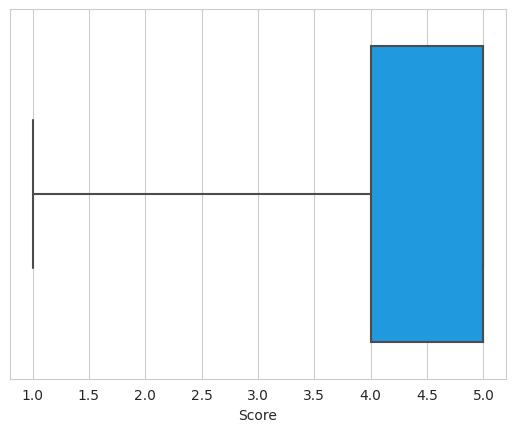

In [10]:
sb.boxplot(x="Score", data=data, whis=5, color="#00a2ff");

## Violin-Plot

>Violin-Plot gives the frequency distribution of the data to visualize how the data is distributed and which points have more concentration of the data

<Axes: ylabel='Score'>

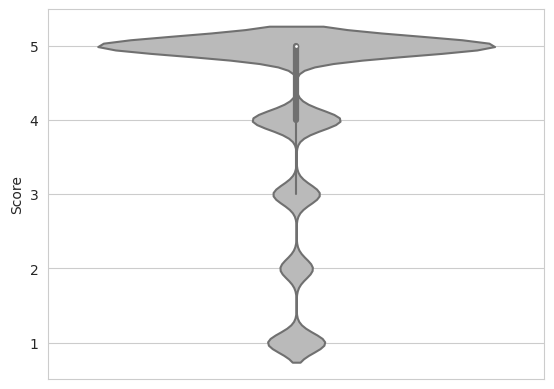

In [11]:
sb.violinplot(y="Score", data=data, bw=0.1, color="#bababa")

### Dropping null values

>Our data does not have any null values, that's why it won't affect data

In [12]:
dataAfter = data.dropna(subset=["Score"])
dataAfter["Score"] = dataAfter["Score"].astype(int)

# Splitting data into TRAIN & TEST datasets

>Data is splitted up after shuffling

In [13]:
split = StratifiedShuffleSplit(n_splits=5, test_size=0.2)
for train_index, test_index in split.split(dataAfter, dataAfter["Score"]): 
    strat_train = dataAfter.reindex(train_index)
    strat_test = dataAfter.reindex(test_index)

>Checking length of the Train dataset and the percentage of each score

In [14]:
len(strat_train)

454763

In [15]:
strat_train["Score"].value_counts()/len(strat_train)

5    0.638790
4    0.141885
1    0.091947
3    0.075010
2    0.052368
Name: Score, dtype: float64

>Checking length of the Test dataset and the percentage of each score

In [16]:
len(strat_test)

113691

In [17]:
strat_test["Score"].value_counts()/len(strat_test)

5    0.638784
4    0.141885
1    0.091951
3    0.075010
2    0.052370
Name: Score, dtype: float64

## Using Shuffled Train Dataset

>Checking the Top 5 Records

In [18]:
reviews = strat_train.copy()
reviews.head()

,ProductId,Score,Summary,Text
217725,B000CQG87Q,5,Licorice tea,I love this stuff. I could drink it three tim...
316232,B000GWLUGU,5,Delicious!,These potato chips are DELICIOUS! I have not ...
393265,B001DKA7HM,1,Not what I ordered,The basket that I ordered (Something Sweet & S...
174675,B007RTR8T8,4,"worked nicely, but not when paired with the s...",I like having 3-4 different shampoo and condit...
107758,B002BFZAT8,1,Frankly Unpleasant,The first bar was ok...not great. Then I foun...


>Finding Number of Unique Products

In [19]:
print(f"Number of unique Product IDs in Trained Data Reviews: ", len(reviews["ProductId"].unique()))

Number of unique Product IDs in Trained Data Reviews:  67605


>Checking basic info of the Data Frame before further processing

In [20]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 454763 entries, 217725 to 443030
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ProductId  454763 non-null  object
 1   Score      454763 non-null  int64 
 2   Summary    454742 non-null  object
 3   Text       454763 non-null  object
dtypes: int64(1), object(3)
memory usage: 17.3+ MB


>Finding Mean of all the ratings of train dataset

In [21]:
reviews["Score"].mean()

4.183203118987253

>Counting Number of reviews of each Product from the Train dataset

In [22]:
counts = reviews["ProductId"].value_counts().to_frame()
counts.head(10)

,ProductId
B007JFMH8M,740
B002QWHJOU,502
B002QWP89S,501
B002QWP8H0,500
B003B3OOPA,497
B0026RQTGE,491
B006HYLW32,467
B001RVFEP2,461
B007M83302,457
B0026KPDG8,454


>Calculating the Mean rating score of each Product in the Train Dataset

In [23]:
avg_rating = reviews.groupby("ProductId")["Score"].mean().to_frame()
avg_rating.head(10)

,Score
ProductId,
0006641040,4.451613
141278509X,5.000000
2734888454,5.000000
2841233731,5.000000
7310172001,4.748148
7310172101,4.758621
7800648702,4.000000
9376674501,5.000000
B00002N8SM,1.696970


>Grouping the Product count and the Mean rating of each product in Train Dataset to form a Table

In [24]:
table = counts.join(avg_rating)
table.head(30)

,ProductId,Score
B007JFMH8M,740,4.585135
B002QWHJOU,502,4.615538
B002QWP89S,501,4.630739
B002QWP8H0,500,4.554000
B003B3OOPA,497,4.742455
B0026RQTGE,491,4.635438
B006HYLW32,467,4.301927
B001RVFEP2,461,4.327549
B007M83302,457,4.273523
B0026KPDG8,454,4.301762


## Scatter Plot

>Scatter plots are used to observe relationships between variables. The dots in a scatter plot not only report the values of individual data points, but also patterns when the data are taken as a whole. Here, we can conclude that the number of times a product being purchased is affecting it's rating either in a good or a bad way. 

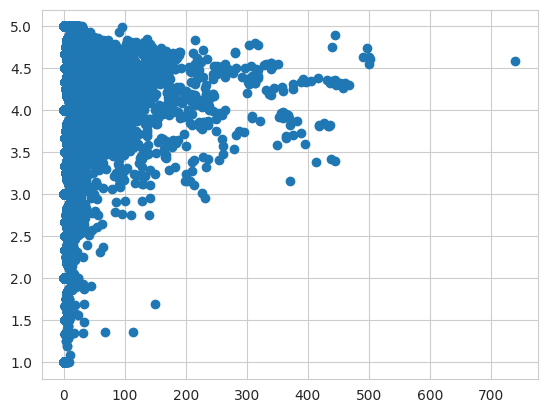

In [25]:
plt.scatter("ProductId", "Score", data=table);

### Classifying the review on the basis of rating

In [26]:
def label_sentiments(rating):
    if (rating == 5) or (rating == 4):
        return "Positive"
    elif rating == 3:
        return "Neutral"
    elif (rating == 2) or (rating == 1):
        return "Negative"

strat_train["Sentiment"] = strat_train["Score"].apply(label_sentiments)
strat_test["Sentiment"] = strat_test["Score"].apply(label_sentiments)

## Calculating Algos' Metrics

#### Calculating Precision, Recall and F-Score of the Algorithm using TP,TN,FP,FN

In [27]:
# Calculating other metrics

def calculate_precision(conf_mat):
    return (conf_mat[2][2]) / (conf_mat[2][2] + conf_mat[2][0])


def calculate_recall(conf_mat):
    return (conf_mat[2][2]) / (conf_mat[2][2] + conf_mat[0][2])


def calculate_f_score(algo_precision, algo_recall):
    return (2*(algo_precision * algo_recall)) / (algo_precision + algo_recall)

## Pre-Processing Data

>Checking Number of Samples

In [28]:
X_train = strat_train["Text"]
X_train_targetSentiment = strat_train["Sentiment"]
X_test = strat_test["Text"]
X_test_targetSentiment = strat_test["Sentiment"]
print(f"Number of Training Samples: {len(X_train)}")
print(f"Number of Test Data Samples: {len(X_test)}")

Number of Training Samples: 454763
Number of Test Data Samples: 113691


> 1 - Filling NA's with EMPTY STRING <br> 2 - Transforming data to Count Vectors - The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words <br> 3 - Getting Number of  Samples and the Distinct Words

In [29]:
X_train = X_train.fillna(' ')
X_test = X_test.fillna(' ')
X_train_targetSentiment = X_train_targetSentiment.fillna(' ')
X_test_targetSentiment = X_test_targetSentiment.fillna(' ')

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape
print(f"Number of Training Samples: {X_train_counts.shape[0]}")
print(f"Number of Distinct Words: {X_train_counts.shape[1]}")

Number of Training Samples: 454763
Number of Distinct Words: 109409


### DF-IDF Transformation

>1 - Stop Word Removal <br> 2 - PoS tagging <br> 3 - We have already tokenize data using CountVectorizer. By using Stop word removal, POS tagging etc. we may not analyse the data correctly because some of the important words that distinguish the class of data get removed. That's why we are using TF-IDF transformation that will automatically assign less weight to unimportant words and the important words or the class distinguishers won't get removed.  Moreover, visit https://www.freecodecamp.org/news/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3/ for detailed explanation

In [30]:
tfidf_transformer = TfidfTransformer(use_idf=False)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape
print(f"Number of Training Samples: {X_train_tfidf.shape[0]}")
print(f"Number of Distinct Words: {X_train_tfidf.shape[1]}")

Number of Training Samples: 454763
Number of Distinct Words: 109409


# Applying Classification Algorithms

## Multinominal Naive Bayes

>It calculates the probability of an occurence based on the training / prior data. It is based on Bayes theorem. For more details visit https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [31]:
# Multinominal Niave Bayes
clf_multiNB_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_nominalNB", MultinomialNB())])
clf_multiNB_pipe.fit(X_train, X_train_targetSentiment)

predictedMultiNB = clf_multiNB_pipe.predict(X_test)
np.mean(predictedMultiNB == X_test_targetSentiment)

0.7982162176425575

>Classification Report and Accuracy Score

In [32]:
# classification_report and accuracy_score
print("Classification Report")
print(f"{classification_report(X_test_targetSentiment, predictedMultiNB)}")
print(f"Accuracy: {accuracy_score(X_test_targetSentiment, predictedMultiNB)}")

Classification Report
              precision    recall  f1-score   support

    Negative       0.92      0.13      0.23     16408
     Neutral       0.12      0.00      0.00      8528
    Positive       0.80      1.00      0.89     88755

    accuracy                           0.80    113691
   macro avg       0.61      0.38      0.37    113691
weighted avg       0.76      0.80      0.72    113691

Accuracy: 0.7982162176425575


>Confusion Matrix (Rows | Columns : Negative, Neutral, Positive)

In [33]:
conf_arr_mnb = metrics.confusion_matrix(X_test_targetSentiment, predictedMultiNB)
conf_arr_mnb

array([[ 2106,     2, 14300],
       [   98,     4,  8426],
       [   87,    28, 88640]])

> Calculating metrics for algorithm as a whole <br> 1 - Precision <br> 2 - Recall <br> 3 - F1-Score 

In [34]:
total_precision = calculate_precision(conf_arr_mnb)
total_recall = calculate_recall(conf_arr_mnb)
total_f_score = calculate_f_score(total_precision, total_recall)

print("Precision of the Algorithm : ", total_precision)
print("Recall  of the   Algorithm : ", total_recall)
print("F-Score  of the  Algorithm : ", total_f_score)

Precision of the Algorithm :  0.9990194641991728
Recall  of the   Algorithm :  0.8610841266757334
F-Score  of the  Algorithm :  0.9249375218477881


## Logistic Regression Classifier

>It computes the probability of an event occurrence. It classify the text according its probability. for more details visit https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

In [35]:
# Logistic Regression Classifier
clf_logReg_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_logReg", LogisticRegression())])
clf_logReg_pipe.fit(X_train, X_train_targetSentiment)

predictedLogReg = clf_logReg_pipe.predict(X_test)
np.mean(predictedLogReg == X_test_targetSentiment)

0.8794451627657422

>Classification Report and Accuracy Score

In [36]:
# classification_report and accuracy_score
print("Classification Report")
print(f"{classification_report(X_test_targetSentiment, predictedLogReg)}")
print(f"Accuracy: {accuracy_score(X_test_targetSentiment, predictedLogReg)}")

Classification Report
              precision    recall  f1-score   support

    Negative       0.77      0.71      0.74     16408
     Neutral       0.56      0.27      0.36      8528
    Positive       0.91      0.97      0.94     88755

    accuracy                           0.88    113691
   macro avg       0.75      0.65      0.68    113691
weighted avg       0.86      0.88      0.87    113691

Accuracy: 0.8794451627657422


>Confusion Matrix (Rows | Columns : Negative, Neutral, Positive)

In [37]:
conf_arr_lrg = metrics.confusion_matrix(X_test_targetSentiment, predictedLogReg)
conf_arr_lrg

array([[11705,   777,  3926],
       [ 1737,  2260,  4531],
       [ 1754,   981, 86020]])

> Calculating metrics for algorithm as a whole <br> 1 - Precision <br> 2 - Recall <br> 3 - F1-Score 

In [38]:
total_precision = calculate_precision(conf_arr_lrg)
total_recall = calculate_recall(conf_arr_lrg)
total_f_score = calculate_f_score(total_precision, total_recall)

print("Precision of the Algorithm : ", total_precision)
print("Recall  of the   Algorithm : ", total_recall)
print("F-Score  of the  Algorithm : ", total_f_score)

Precision of the Algorithm :  0.9800168614851779
Recall  of the   Algorithm :  0.9563515887310163
F-Score  of the  Algorithm :  0.968039612874184


## Support Vector Machine Classifier

>The classifier separates data points using a hyperplane with the largest amount of margin. SVM finds an optimal hyperplane which helps in classifying new data points. For more details, visit https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python

In [39]:
# Support Vector Machine Classifier
clf_linearSVC_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_linearSVC", LinearSVC())])
clf_linearSVC_pipe.fit(X_train, X_train_targetSentiment)

predictedLinearSVC = clf_linearSVC_pipe.predict(X_test)
np.mean(predictedLinearSVC == X_test_targetSentiment)

0.8886895180797073

>Classification Report and Accuracy Score

In [40]:
# classification_report and accuracy_score
print("Classification Report")
print(f"{classification_report(X_test_targetSentiment, predictedLinearSVC)}")
print(f"Accuracy: {accuracy_score(X_test_targetSentiment, predictedLinearSVC)}")

Classification Report
              precision    recall  f1-score   support

    Negative       0.78      0.75      0.76     16408
     Neutral       0.66      0.28      0.40      8528
    Positive       0.92      0.97      0.94     88755

    accuracy                           0.89    113691
   macro avg       0.79      0.67      0.70    113691
weighted avg       0.88      0.89      0.88    113691

Accuracy: 0.8886895180797073


>Confusion Matrix (Rows | Columns : Negative, Neutral, Positive)

In [41]:
conf_arr_svm = metrics.confusion_matrix(X_test_targetSentiment, predictedLinearSVC)
conf_arr_svm

array([[12269,   544,  3595],
       [ 1764,  2422,  4342],
       [ 1707,   703, 86345]])

> Calculating metrics for algorithm as a whole <br> 1 - Precision <br> 2 - Recall <br> 3 - F1-Score 

In [42]:
total_precision = calculate_precision(conf_arr_svm)
total_recall = calculate_recall(conf_arr_svm)
total_f_score = calculate_f_score(total_precision, total_recall)

print("Precision of the Algorithm : ", total_precision)
print("Recall  of the   Algorithm : ", total_recall)
print("F-Score  of the  Algorithm : ", total_f_score)

Precision of the Algorithm :  0.9806137282514877
Recall  of the   Algorithm :  0.9600289081609962
F-Score  of the  Algorithm :  0.9702121443660389


## Decision Tree Classifier

>A decision tree is a flowchart-like tree structure where an internal node represents feature, the branch represents a decision rule, and each leaf node represents the outcome. For more details visit https://www.datacamp.com/community/tutorials/decision-tree-classification-python

In [ ]:
# Decision Tree Classifier
clf_decisionTree_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), 
                                  ("clf_decisionTree", DecisionTreeClassifier())])
clf_decisionTree_pipe.fit(X_train, X_train_targetSentiment)

predictedDecisionTree = clf_decisionTree_pipe.predict(X_test)
np.mean(predictedDecisionTree == X_test_targetSentiment)

>Classification Report and Accuracy Score

In [ ]:
# classification_report and accuracy_score
print("Classification Report")
print(f"{classification_report(X_test_targetSentiment, predictedDecisionTree)}")
print(f"Accuracy: {accuracy_score(X_test_targetSentiment, predictedDecisionTree)}")

>Confusion Matrix (Rows | Columns : Negative, Neutral, Positive)

In [ ]:
conf_arr_dct = metrics.confusion_matrix(X_test_targetSentiment, predictedDecisionTree)
conf_arr_dct

> Calculating metrics for algorithm as a whole <br> 1 - Precision <br> 2 - Recall <br> 3 - F1-Score 

In [ ]:
total_precision = calculate_precision(conf_arr_dct)
total_recall = calculate_recall(conf_arr_dct)
total_f_score = calculate_f_score(total_precision, total_recall)

print("Precision of the Algorithm : ", total_precision)
print("Recall  of the   Algorithm : ", total_recall)
print("F-Score  of the  Algorithm : ", total_f_score)

## Random Forest Classifier

>Random forests creates decision trees on randomly selected data samples, gets prediction from each tree and selects the best solution by means of voting. For more details visit https://www.datacamp.com/community/tutorials/random-forests-classifier-python

In [ ]:
# Random Forest Classifier
clf_randomForest_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_randomForest", RandomForestClassifier())])
clf_randomForest_pipe.fit(X_train, X_train_targetSentiment)

predictedRandomForest = clf_randomForest_pipe.predict(X_test)
np.mean(predictedRandomForest == X_test_targetSentiment)

>Classification Report and Accuracy Score

In [ ]:
# classification_report and accuracy_score
print("Classification Report")
print(f"{classification_report(X_test_targetSentiment, predictedRandomForest)}")
print(f"Accuracy: {accuracy_score(X_test_targetSentiment, predictedRandomForest)}")

>Confusion Matrix (Rows | Columns : Negative, Neutral, Positive)

In [ ]:
conf_arr_rfc = metrics.confusion_matrix(X_test_targetSentiment, predictedRandomForest)
conf_arr_rfc

> Calculating metrics for algorithm as a whole <br> 1 - Precision <br> 2 - Recall <br> 3 - F1-Score 

In [ ]:
total_precision = calculate_precision(conf_arr_rfc)
total_recall = calculate_recall(conf_arr_rfc)
total_f_score = calculate_f_score(total_precision, total_recall)

print("Precision of the Algorithm : ", total_precision)
print("Recall  of the   Algorithm : ", total_recall)
print("F-Score  of the  Algorithm : ", total_f_score)

## Grid Search CV Real-time Prediction

In [ ]:
# Grid Search CV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],    
             'tfidf__use_idf': (True, False), 
             } 
gs_clf_LinearSVC_pipe = GridSearchCV(clf_linearSVC_pipe, parameters, n_jobs=-1)
gs_clf_LinearSVC_pipe = gs_clf_LinearSVC_pipe.fit(X_train, X_train_targetSentiment)
new_text = ["The headphones are really good, I will buy some more products online from amazon.", 
            "The phone is ok, but it works fine.", 
            "The handfree is not good, does not work very well.", "The iphone is not good", "This TV is so good and is on cheap price."] 

gs_clf_LinearSVC_pipe.predict(new_text)

In [ ]:
predictedGS_clf_LinearSVC_pipe = gs_clf_LinearSVC_pipe.predict(X_test)
np.mean(predictedGS_clf_LinearSVC_pipe == X_test_targetSentiment)

In [ ]:
for performance_analysis in (gs_clf_LinearSVC_pipe.best_score_, 
                             gs_clf_LinearSVC_pipe.best_estimator_, 
                             gs_clf_LinearSVC_pipe.best_params_):
        print(performance_analysis)

>Classification Report and Accuracy Score

In [ ]:
# classification_report and accuracy_score
print("Classification Report")
print(f"{classification_report(X_test_targetSentiment, predictedGS_clf_LinearSVC_pipe)}")
print(f"Accuracy: {accuracy_score(X_test_targetSentiment, predictedGS_clf_LinearSVC_pipe)}")

>Confusion Matrix (Rows | Columns : Negative, Neutral, Positive)

In [ ]:
conf_arr_gs = metrics.confusion_matrix(X_test_targetSentiment, predictedGS_clf_LinearSVC_pipe)
conf_arr_gs

> Calculating metrics for algorithm as a whole <br> 1 - Precision <br> 2 - Recall <br> 3 - F1-Score 

In [ ]:
total_precision = calculate_precision(conf_arr_gs)
total_recall = calculate_recall(conf_arr_gs)
total_f_score = calculate_f_score(total_precision, total_recall)

print("Precision of the Algorithm : ", total_precision)
print("Recall  of the   Algorithm : ", total_recall)
print("F-Score  of the  Algorithm : ", total_f_score)